# Nufflytics: Analyzing Blood Bowl matches from FUMBBL using Python

This blogpost is about **Blood Bowl**, a strategic boardgame invented in the late 80's, that I finally started playing last year. Blood bowl is a game of Fantasy Football, where fantasy team races (think "Orcs", or "Elves") are pitted against each other. Interestingly, the various teams (there are over 20 different ones) require different play styles, and not all team races are equally strong. On tournaments, this gives rise to various compensation schemes to make all teams "viable" for competition. There exists a lively tournament scene, with thousands of matches played each year. 

The idea of this blog post is to showcase some possible analyses that can be done on the [FUMBBL match data I've compiled](https://gsverhoeven.github.io/post/blood-bowl-fumbbl-dataset/). The idea is to make Blood Bowl data analysis (also know as [Nufflytics](https://nufflytics.com), a term coined by Blood Bowler "Schlice" in reference to Nuffle, the god of Blood Bowl) easier and more accessible to others. I took inspiration from various sources, detailed at the end of this post. So lets dive in the world of Blood Bowl stats nerdery.

# Getting started with the data

Since the previous blog post on FUMBBL data, I decided to make a separate Github repository [fumbbl_datasets](https://github.com/gsverhoeven/fumbbl_datasets) that contains the Python code to fetch and construct the FUMBBL datasets. You can either download the latest datasets manually, or clone the entire repo to your local drive, depending on your expertise and preferences.

The datasets are available both in CSV and HDF5. CSV would be the format of choice for Excel analysis, whereas the HDF5 format is suitable for scripted languages such as Python or R. Here we use Python, with the libraries `Pandas` and `plotnine` for data analysis and visualization. The code below assumes the datasets are locally stored at the location contained in the `path_to_datasets` variable:

In [1]:
import pandas as pd
import numpy as np
import plotnine as p9

# point this to the location of the HDF5 datasets
path_to_datasets = '../../../../fumbbl_datasets/'

# FUMBBL matches
target = 'datasets/v0.2/df_matches.h5'
df_matches = pd.read_hdf(path_to_datasets + target) 

# FUMBBL matches by team
target = 'datasets/v0.2/df_mbt.h5'
df_mbt = pd.read_hdf(path_to_datasets + target) 

# FUMBBL inducements
target = 'datasets/v0.2/inducements.h5'
inducements = pd.read_hdf(path_to_datasets + target) 

KeyboardInterrupt: 

# What data do we have? Weekly game volumes


Let's see what we've got! The pandas DataFrame `df_matches` contains records for all matches played on FUMBBL between august 2020 and march 2022.

Since we have a proper `datetime` type variable for each week (`week_date`), we can use `pandas` and `plotnine` to plot the weekly game volume as a time series.

The introduction of the new **Competitive division** with BB2020 rules is marked by a vertical red line. I labeled the larger leagues as well a recent tournament I took part in myself.

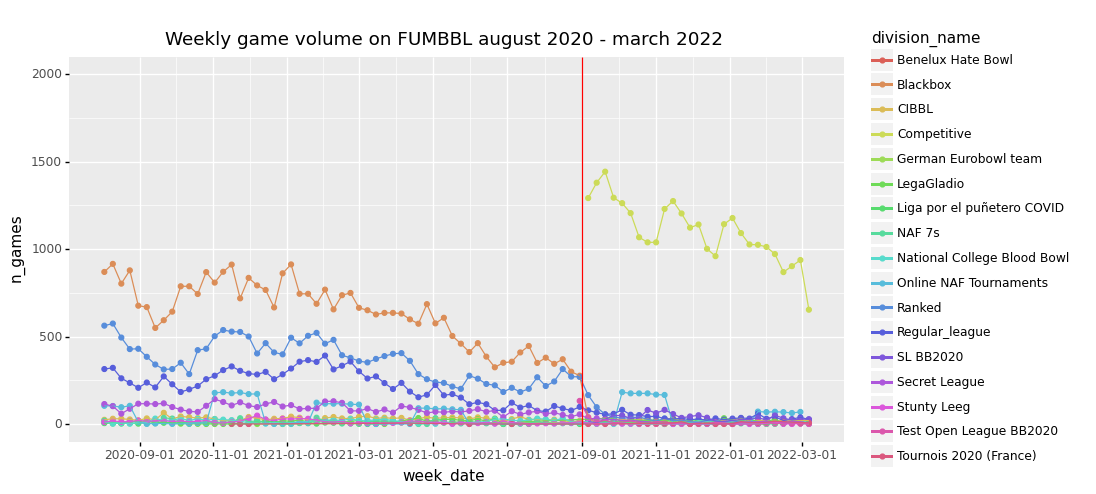

<ggplot: (-9223363302253724542)>

In [2]:
res = (df_matches
    .loc[(df_matches['week_date'] >= '2020-08-01' ) & (df_matches['week_date'] < '2022-11-25')]
    .groupby(['week_date', 'week_number', 'division_name'])
    .agg(        
        n_games = ('match_id', "count") 
    )
    .reset_index()) # this adds the "group by" variables back as columns of res

(p9.ggplot(data = res, mapping = p9.aes(x = 'week_date', y = 'n_games', color = 'division_name'))
+ p9.geom_point() 
+ p9.geom_line()
+ p9.expand_limits(y=[0,2000])
+ p9.geom_vline(xintercept = '2021-09-01', color = "red")
+ p9.theme(figure_size = (10, 5))
+ p9.ggtitle("Weekly game volume on FUMBBL august 2020 - march 2022"))

To check the dataset, I compared this plot with the plot of weekly game volumes that FUMBBL itself provides at https://fumbbl.com/p/stats.
Both plots looked identical at the time of writing, so it seems that we have a complete dataset for the given period.

The effect of starting the new BB2020 Competitive division is clearly visible, with the weekly game volume almost doubling in september 2021.
The first online NAF tournament using BB2020 rules is also visible, running for 6 weeks in October / November 2021.

# Star player usage on FUMBBL

We can also look at the percentage of matches that involve star players.
I used the various plot aesthetics like symbol shape and size to encode the game volume and ruleset (BB2016 or BB2020 based).

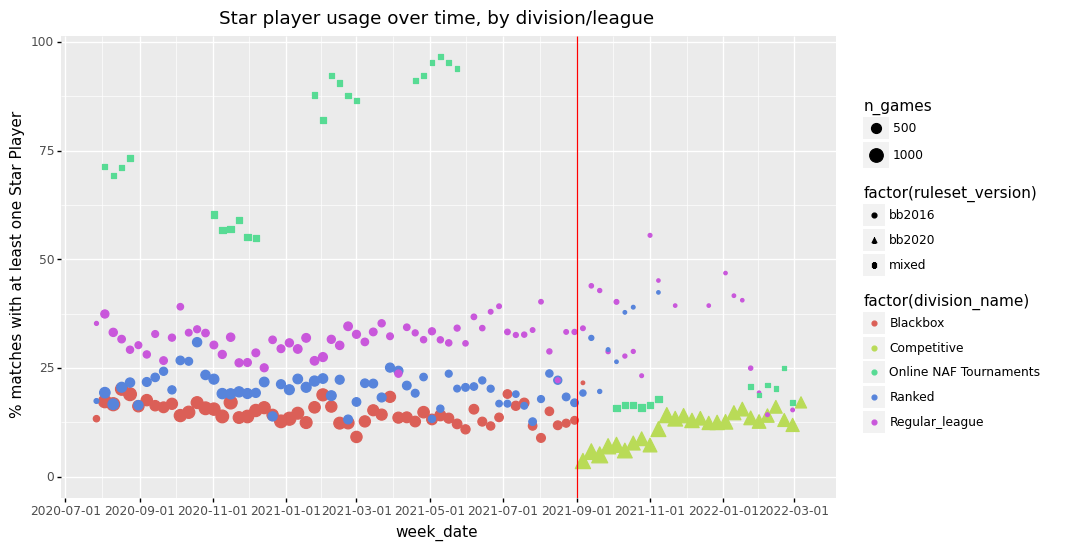

<ggplot: (-9223363302246313763)>

In [3]:
divisions = ['Blackbox', 'Competitive', 'Online NAF Tournaments',  'Ranked', 'Regular_league']

res = (df_matches
.query("division_name in @divisions")
.groupby(['division_name', 'league', 'ruleset', 'ruleset_version', 'week_date'])
.agg(
    n_games = ('match_id', 'count'),
    perc_sp = ('has_sp', 'mean')
)
.reset_index()
.sort_values("n_games", ascending=False)
)

(p9.ggplot(data = res.query("n_games > 30"), mapping = p9.aes(x = 'week_date', y = 'perc_sp*100', 
group = 'factor(division_name)', color = 'factor(division_name)'))
    + p9.geom_point(p9.aes(shape = 'factor(ruleset_version)', size = 'n_games')) 
    + p9.expand_limits(y=[0,1])
    + p9.scale_size_area()
    + p9.geom_vline(xintercept = '2021-09-01', color = "red")
    + p9.ggtitle("Star player usage over time, by division/league")
    + p9.theme(figure_size = (10, 6))
    + p9.ylab("% matches with at least one Star Player"))
    

In above graph, the various online NAF Tournaments are clearly distinguished. **Amorical Cup 2020** in summer 2020, **Eur'Open Online** in Nov/dec 2020, **SteelBowl** in Feb 2021, and **LitBowl** in May 2021 were all using BB2016 rules. 

Through Googling and using the Wayback Machine, I was able to find the rulepacks of these tournaments.  LitBowl featured "big budgets" (up to 1440K) and a requirement of only 10 regular players before inducement, this likely explains the large amount of Star Players in that tournament. 

In contrast, in the GBFU tournament, the first online NAF tournament using the BB2020 rules, only some 15% of matches involved at least one star player. 

# Are coach ratings predictive of match outcomes?

For the main divisions on FUMBBL, ELO style coach ratings are available that are updated after each game.
The coach rankings are explained on [this help page](https://fumbbl.com/help:Ranking).

According to the ELO ranking system, a coach rating difference of 40 should result in 85% wins for the higher ranked coach.
Coaches of equal rating should have a win rate of 0.5 (with draws weighted at half point).

The range of coach rankings observed for a particular game tells us something about the relationship between skill and luck.
If a game is pure luck, we will never observe large differences in coach rating, since the outcome will be determined by a coin flip, independent of coach skill. 

On FUMBBL, coach ratings vary roughly between 125 and 175. What do we expect if a coach with a rating of 175 plays a coach of rating 145? Well, the rating difference is 30. According to the formula (assuming equal team strength and equal races), the expected win probability is 1/(1 + 10^0.75) = 85%, and the probability of loss is 15%.

Since our CR we obtained from the FUMBBL match result page is an overall coach rating (i.e. it ignores division), we can simply pool all matches from divisions where coach rating is tracked.

The match data contains a **Coach Ranking Difference** bin (category) that we can each to calculate the Win/draw/loss percentages for each category.

Let's see what the actual percentages are:

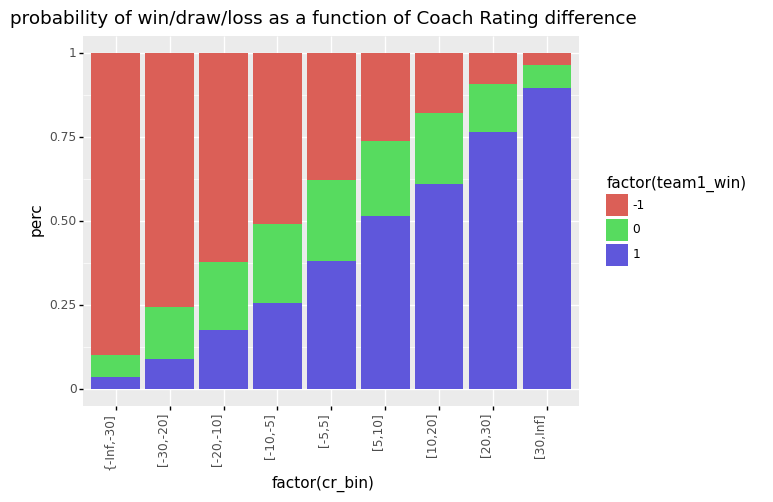

<ggplot: (-9223363302350291624)>

In [4]:
main_divisions = ['Blackbox', 'Ranked', 'Competitive']

res = (df_matches[df_matches['division_name'].isin(main_divisions)]
    .groupby(['cr_bin', 'team1_win'])
    .agg(        
        n_games = ('cr_bin', "count"),
    )
    .reset_index()) # this adds the group by variable (now index) as a column

# add total games played within each bin
res['n_games_bin'] = res.groupby('cr_bin').n_games.transform('sum')

res['perc'] = res['n_games']/res['n_games_bin']

(p9.ggplot(res, p9.aes(x = 'factor(cr_bin)', y = 'perc', fill = 'factor(team1_win)')) 
    + p9.geom_bar(position = "fill", stat = "identity") 
    + p9.theme(axis_text_x= p9.element_text(rotation=90, hjust=1))
    + p9.ggtitle('probability of win/draw/loss as a function of Coach Rating difference')
)

(Note that I made the bins for large CR differences (greater than 10) wider to get more games per bin.)

From above graphs, we can conclude that the coach ratings work as expected, with large coach rating differences indeed showing high win rates for the higher ranked coach. From this we can infer that a highly skilled coach will win 9 times out of ten agains a below average coach. We call Blood Bowl a Strategy game for a reason!

# What about the passing game in BB2020?

With Blood Bowl 2020 also came a large change to passing the ball. Passing is no longer linked to the **Agility** statistics, but now has its own **Passing** (PA) stat. Overall, passing became riskier, and high agility teams do not automatically have good passing stats. For example, only a High Elf thrower has a PA of 2+, whereas the rest of the players have a PA of 4+ or higher. On the Dark Elf team, the player with the best PA stat is the runner, with a PA of 3+, without a built in re-roll. So we can expect quite some changes in the number of completions per match. For more detail I refer to a nice post by king_ghidra at [Blood Bowl Strategies](https://bloodbowlstrategies.com/en/tactics-blood-bowl-second-season/).

Let's have a look!

/home/gertjan/venvs/requests_env/lib/python3.6/site-packages/plotnine/scales/scale_shape.py:85: PlotnineWarning: Using shapes for an ordinal variable is not advised.


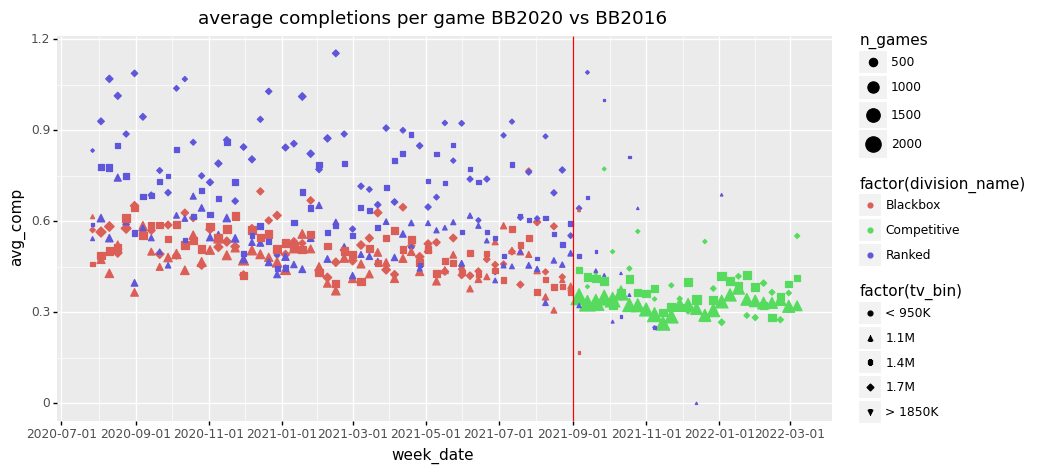

<ggplot: (-9223363302350371093)>

In [5]:
divisions = ['Ranked', 'Blackbox', 'Competitive']

tv_bins = ['1.1M', '1.4M', '1.7M']

res = (df_mbt[df_mbt['division_name'].isin(divisions)]
    .loc[df_mbt['tv_bin'].isin(tv_bins)]
    .query("mirror_match == 0 & has_sp == 0 & tv_bin in @tv_bins & division_name in @divisions")
    .groupby(['division_name', 'ruleset_version', 'week_date', 'tv_bin'])
    .agg(        
        avg_comp = ('home_comp', "mean"),
        avg_pass = ('home_pass', "mean"),
        avg_foul = ('home_foul', "mean"),
        avg_block = ('home_block', "mean"),    
        avg_cas = ('home_cas', "mean"),  
        avg_rcv_cas = ('away_cas', "mean"),
        n_games = ('race_name', "count")
    )
    .sort_values( 'n_games', ascending = False)
    .reset_index()) # this adds the group by variables (now index) as a column

res = res.dropna()

(p9.ggplot(data = res.query('n_games > 10'), 
            mapping = p9.aes(x = 'week_date', y = 'avg_comp', 
                            size = 'n_games', color = 'factor(division_name)', shape = 'factor(tv_bin)'))
    + p9.geom_point()
    + p9.scale_size_area() 
    + p9.geom_vline(xintercept = '2021-09-01', color = "red")    
    + p9.theme(figure_size = (10, 5))
    + p9.ggtitle("average completions per game BB2020 vs BB2016"))

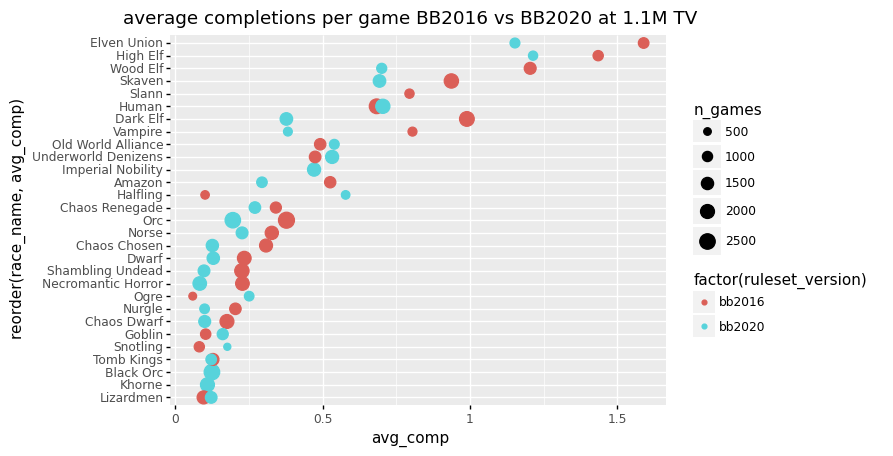

<ggplot: (-9223363302350232432)>

In [6]:
divisions = ['Ranked', 'Blackbox', 'Competitive']

tv_bins = ['1.1M', '1.4M', '1.7M']

res = (df_mbt[df_mbt['division_name'].isin(divisions)]
    .loc[df_mbt['tv_bin'].isin(tv_bins)]
    .query("mirror_match == 0 & has_sp == 0 & tv_bin in @tv_bins & division_name in @divisions")
    .groupby(['ruleset_version', 'race_name', 'tv_bin'])
    .agg(        
        avg_comp = ('home_comp', "mean"),
        avg_pass = ('home_pass', "mean"),
        avg_foul = ('home_foul', "mean"),
        n_games = ('race_name', "count")
    )
    .sort_values( 'n_games', ascending = False)
    .reset_index()) # this adds the group by variables (now index) as a column

res = res.dropna()

(p9.ggplot(data = res.query('n_games > 10 & tv_bin == "1.1M"'), 
            mapping = p9.aes(y = 'reorder(race_name, avg_comp)', x = 'avg_comp', 
                            size = 'n_games', group = 'factor(ruleset_version)', 
                            color = 'factor(ruleset_version)'))
    + p9.geom_point()
    + p9.scale_size_area() 
    + p9.ggtitle("average completions per game BB2016 vs BB2020 at 1.1M TV"))

Across the board we see a decrease in average completions per match. Note that this is for low team values, at around 1.1M, between 950K and 1250K. 

Observations that stand out: 

* High agility teams such as Elven Union, Wood Elf and Skaven show large drops,
* Dark elves show the largest relative drop (more than halving in completions), 
* High Elves are hardly affected, as well as Humans,
* Halflings show a large increase.

# And what about fouling in BB2020?

Also for fouling Blood Bowl 2020 brought some changes to the rules. The **Sneaky Git** skill became better, allowing a player to continue moving after the foul has been committed. The **Black Orcs** were added as a new team, that show fouling potential: they have access to cheap bribes, the **Grab** skill to set up a foul, and cheap goblin bruisers to quickly move around the pitch. And there was of course the **swarming** for the Underworld and Snotling teams, that provides a continuous supply of disposable players to foul with. For more detail I refer to a nice post by king_ghidra at [Blood Bowl Strategies](https://bloodbowlstrategies.com/en/tactics-blood-bowl-second-season/).

Let's see how the stats were affected!

/home/gertjan/venvs/requests_env/lib/python3.6/site-packages/plotnine/scales/scale_shape.py:85: PlotnineWarning: Using shapes for an ordinal variable is not advised.


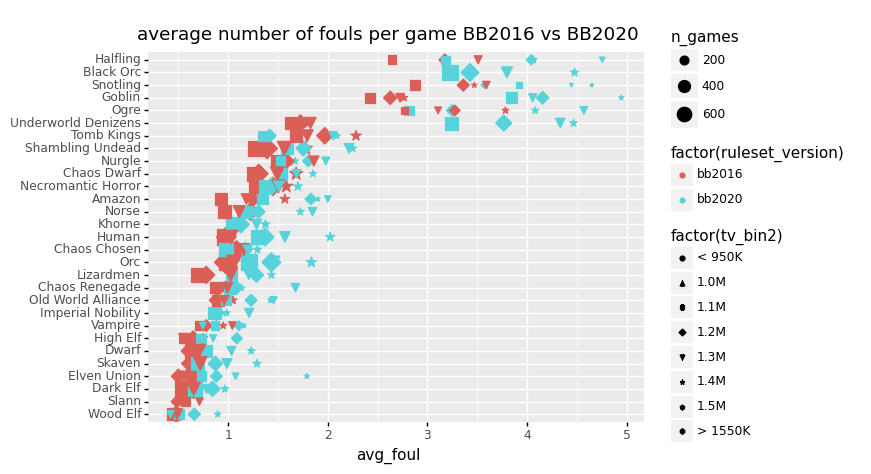

<ggplot: (8734504437775)>

In [7]:
divisions = ['Ranked', 'Blackbox', 'Competitive']

tv_bins = ['1.1M', '1.2M', '1.3M', '1.4M']

res = (df_mbt[df_mbt['division_name'].isin(divisions)]
    .loc[df_mbt['tv_bin2'].isin(tv_bins)]
    .query("mirror_match == 0 & has_sp == 0 & tv_bin2 in @tv_bins & division_name in @divisions")
    .groupby(['ruleset_version', 'race_name', 'tv_bin2'])
    .agg(        
        avg_comp = ('home_comp', "mean"),
        avg_pass = ('home_pass', "mean"),
        avg_foul = ('home_foul', "mean"),
        n_games = ('race_name', "count")
    )
    .sort_values( 'n_games', ascending = False)
    .reset_index()) # this adds the group by variables (now index) as a column

res = res.dropna()

(p9.ggplot(data = res.query('n_games > 10'), 
            mapping = p9.aes(y = 'reorder(race_name, avg_foul)', x = 'avg_foul', 
                            size = 'n_games', color = 'factor(ruleset_version)', 
                            shape = 'factor(tv_bin2)'))
    + p9.geom_point()
    + p9.scale_size_area() 
    + p9.ggtitle("average number of fouls per game BB2016 vs BB2020")
    + p9.ylab(""))

From this plot, we can see that BB2020 indeed shows increased fouling across the board. As expected, the Black Orcs are high up in the fouling charts, and we see large increases in fouling for Underworld, Goblins, Halflings and Snotlings. We can also see that as teams develop, fouling typically increases, possible related to developing a specialized fouling player with the sneaky git skill. For humans access to cheap agile halfling hopefulls with access to sneaky git increased fouling opportunity. In Orc teams goblins can forfill this role.

# Competitive division win rates and Malta Eurobowl 2022 tiers

Last but not least, a win rate analysis. In a tournament setting, elaborate tiering systems are in place to compensate for differences in race strength, skills are selected from skill packs, and player casualties are forgotten with each match played with a "resurrected" fresh team. Furthermore, opponents are randomly assigned and must be played. Contrast this with the FUMBBL Competitive division: Here teams start with 1M gold and without any extra skills. Teams must be developed, like in a league, and opponents can be strategically chosen based on which race they play, their coach rating etc. 

With all this in mind, I tried the impossible: to compare relative team strength as expected by the tournament tiers, with the observed win rates in the Competitive Division. With the Eurobowl 2022 in Malta coming up, I decided to approximate the conditions of that rulepack. Teams are created using 1.15M gold, as well as roughly 36 SPP worth of skills. This translates to 6 primary skills worth 20K, giving us a total team value of 1270K, say around 1.3M.

To correct for differences in coaching ability, I restricted the match selection for matches where coach ratings are not too different (< 10), and above 150. I excluded matches involving Star players, and mirror matches (I.e. Orcs vs Orcs). 
To distinguish the relatively small % differences in win rate, we need to have a bandwidth around 1.3M to get sufficient statistics for each team.
I included confidence intervals to visualize the statistical uncertainty for the win rates.

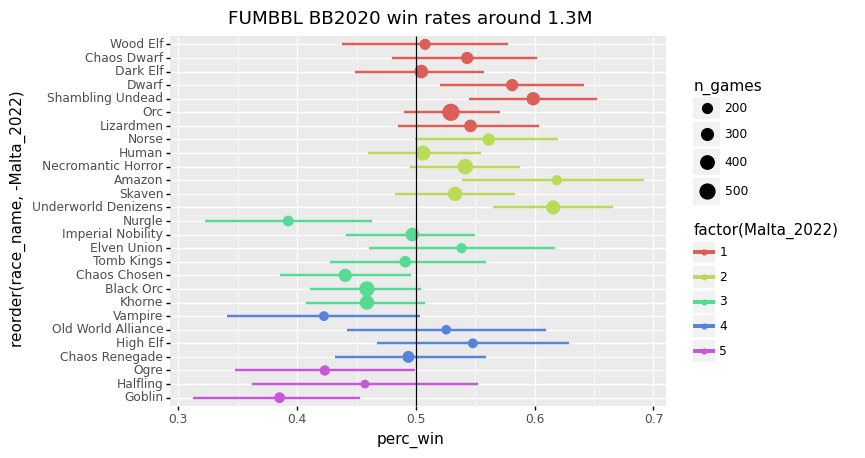

<ggplot: (-9223363302334269892)>

In [8]:
# Function for computing confidence intervals
from statsmodels.stats.proportion import proportion_confint   

divisions = ['Competitive']

tv_bins = ['1.2M', '1.3M', '1.4M']

res = (df_mbt[df_mbt['division_name'].isin(divisions)]
    .loc[df_mbt['tv_bin2'].isin(tv_bins)]
    .query('mirror_match == 0 & has_sp == 0 & CR_diff < 10 & coach_CR > 150')
    .groupby(['race_name', 'ruleset_version', 'Malta_2022'])
    .agg(        
        perc_win = ('wins', "mean"),
        n_wins = ('wins', "sum"),
        n_games = ('race_name', "count")
    )
    .query('n_games > 0')
    .reset_index()) # this adds the group by variable (now index) as a column

res['lower_CI'], res['upper_CI'] =  proportion_confint(
                                      count = round(res['n_wins']).astype(int),
                                      nobs = res['n_games'],
                                      alpha = 0.05
                                  )

(p9.ggplot(data = res.query('n_games > 30'), 
            mapping = p9.aes(x = 'reorder(race_name, -Malta_2022)', y = 'perc_win', 
            size = 'n_games', color = 'factor(Malta_2022)'))
    + p9.geom_linerange(p9.aes(ymin = 'lower_CI', ymax = 'upper_CI'), size = 1)
    + p9.geom_point()
    + p9.scale_size_area() 
    + p9.coord_flip()
    + p9.geom_hline(yintercept = 0.5)
    + p9.ggtitle("FUMBBL BB2020 win rates around 1.3M"))


First off, I think the most important lesson here is that it is really difficult to compare win rates across such different settings.

But what info can we squeeze from this plot nevertheless:

It seems that Amazon and Underworld have higher FUMBBL win rates than expected based on their Malta 2022 tier.

* For Amazon, this might be due to being able to avoid particular opponents on FUMBBL, such as Dwarves and Chaos Dwarves, with a lot of Tackle.
* For Underworld, this is likely related to their improvements in BB2020, leading the charts at NAF tournaments, that resulted in recent rule changes that weakened them with the November 2021 Games Workshop ruling. 

What else do we got:

* Nurgle has a relatively low win rate compared to other teams with the same tier.
* High Elf has a low tier, but shows an above average win rate, and appears to perform well at NAF tournaments. Curious to see how this race will do this year.


# Concluding Remarks and acknowledgements

The analyses above hopefully give you some idea what can be with the rich FUMMBL data available.

One last application: The data can also be used to search for matches based on highly particular search criteria: for example, if you are interested in Snotling matches that induce Morg N Thorg and play against a skilled Elf coach. The `match_id` can then be used to watch the replay on FUMBBL. 

Finally, some acknowledgements. While writing this blog, I drew inspiration from several sources:

* most notable the [FUMBBL website itself](https://www.fumbbl.com) that has a wealth of statistics available, 
* the [website of FUMBBL coach Koadah](https://fumbbldata.azurewebsites.net/stats.html) with aggregated FUMBBL stats, 
* the [NAF monthly reports](https://public.tableau.com/app/profile/mike.sann0638.davies/viz/TheNAFReport/Games) by Mike Davies, 
* a [blog post on team strength](https://bloodbowlstrategies.com/en/relative-strength-of-teams/) by Taureau Amiral , 
* the [Nufflytics blog](https://nufflytics.com) by Blood Bowl 2 coach Schlice,
* the various technical posts of [FUMBBL coach Adam Szieberth](https://fumbbl.com/~SzieberthAdam) who followed a similar approach using Python API and web scraping FUMBBL data. 